In [2]:
! pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=25b494cdb4aa7c332f0c6446c00282ec2547d3959d6c0808d3e196fd116b6d76
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import ta # Technical Analysis library
from sklearn.preprocessing import StandardScaler # For state normalization
import copy # For deep copying target network

In [4]:
# --- Configuration ---
TICKER = 'AAPL'       # Stock ticker symbol (e.g., 'AAPL', 'MSFT', 'GOOGL')
PERIOD = '5y'         # Data period (e.g., '1y', '5y', 'max')
INTERVAL = '1d'       # Data interval (e.g., '1d', '1wk', '1h')
N_LAGS = 5            # Number of lagged features to include
INITIAL_BALANCE = 10000 # Starting cash balance
TRANSACTION_COST_PCT = 0.001 # Transaction cost percentage (0.1%)

# --- DQN Hyperparameters ---
BUFFER_SIZE = int(1e5)  # Replay buffer size
BATCH_SIZE = 64         # Minibatch size
GAMMA = 0.99            # Discount factor
LR = 5e-4               # Learning rate
TAU = 1e-3              # For soft update of target parameters
UPDATE_EVERY = 4        # How often to update the network
TARGET_UPDATE_EVERY = 100 # How often to update the target network hard/soft

# --- Exploration ---
EPS_START = 1.0         # Starting epsilon for exploration
EPS_END = 0.01          # Minimum epsilon
EPS_DECAY = 0.995       # Epsilon decay rate

# --- Training ---
NUM_EPISODES = 500      # Number of training episodes
MAX_T = 10000           # Maximum number of timesteps per episode (can be len(data))

# --- Device ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# --- Data Loading and Feature Engineering ---
def load_and_prepare_data(ticker, period, interval, n_lags):
    """Loads data, calculates indicators, adds lags, and scales features."""
    print(f"Loading data for {ticker}...")
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval, auto_adjust=True)
    data.dropna(inplace=True) # Drop rows with missing values (e.g., holidays)

    if data.empty:
        raise ValueError(f"No data loaded for {ticker}. Check ticker symbol or period/interval.")

    print("Calculating technical indicators...")
    # Add technical indicators using the 'ta' library
    # data = ta.add_all_ta_features(
    #     data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    # )
    # Selecting a subset for clarity and performance
    data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'], window=14).rsi()
    macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
    data['MACD'] = macd.macd()
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_diff'] = macd.macd_diff()
    bb = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
    data['BB_high_ind'] = bb.bollinger_hband_indicator()
    data['BB_low_ind'] = bb.bollinger_lband_indicator()
    data['ATR'] = ta.volatility.AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=14).average_true_range()
    # Add more indicators as needed...

    # Select base features + indicators
    feature_cols = ['Close', 'Volume', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_high_ind', 'BB_low_ind', 'ATR']
    base_features = data[feature_cols].copy() # Use copy to avoid SettingWithCopyWarning

    # Create lagged features
    print(f"Creating {n_lags} lagged features...")
    lagged_features = []
    for lag in range(1, n_lags + 1):
        shifted = base_features.shift(lag)
        shifted.columns = [f'{col}_lag{lag}' for col in base_features.columns]
        lagged_features.append(shifted)

    # Combine base features and lagged features
    full_features = pd.concat([base_features] + lagged_features, axis=1)

    # Drop rows with NaNs introduced by indicators and lags
    original_len = len(data)
    full_features.dropna(inplace=True)
    data = data[data.index.isin(full_features.index)] # Align original data with features
    print(f"Data shape after feature engineering and NaN drop: {full_features.shape}")
    print(f"Dropped {original_len - len(full_features)} rows due to NaNs.")

    if full_features.empty:
        raise ValueError("No data left after feature engineering and NaN drop. Check indicator/lag settings.")

    # --- Feature Scaling ---
    # Important: Scale features for better NN performance
    # In a real scenario, fit the scaler ONLY on the training data
    # and use it to transform both training and test data.
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features_np = scaler.fit_transform(full_features)
    scaled_features = pd.DataFrame(scaled_features_np, index=full_features.index, columns=full_features.columns)

    return data, scaled_features, scaler # Return original data, scaled features, and the scaler

In [6]:
# --- Trading Environment ---
class TradingEnv:
    def __init__(self, stock_data, feature_data, initial_balance=10000, transaction_cost_pct=0.001):
        self.stock_data = stock_data # Original data with prices
        self.feature_data = feature_data # Scaled features for state
        self.initial_balance = initial_balance
        self.transaction_cost_pct = transaction_cost_pct
        self.n_steps = len(self.feature_data)
        self.current_step = 0

        # State dimension: number of features
        self.state_dim = self.feature_data.shape[1]
        # Action space: 0: Hold, 1: Buy, 2: Sell
        self.action_space_n = 3

        self._reset()

    def _reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.trade_history = [] # To store (step, action, price, shares, cost)
        self.total_reward = 0
        return self._get_state()

    def _get_state(self):
        if self.current_step < self.n_steps:
            return self.feature_data.iloc[self.current_step].values
        else:
            # Return a zero state or handle appropriately if needed
            return np.zeros(self.state_dim)

    def _get_current_price(self):
        return self.stock_data['Close'].iloc[self.current_step]

    def step(self, action):
        """Executes one time step within the environment."""
        if self.current_step >= self.n_steps -1 : # Prevent index out of bounds
             return self._get_state(), 0, True, {} # End of data

        prev_net_worth = self.net_worth
        current_price = self._get_current_price()
        cost = 0
        trade_executed = False

        # Execute action
        if action == 1: # Buy
            if self.balance > 0:
                shares_to_buy = self.balance / (current_price * (1 + self.transaction_cost_pct))
                cost = shares_to_buy * current_price * self.transaction_cost_pct
                self.shares_held += shares_to_buy
                self.balance -= shares_to_buy * current_price + cost
                self.trade_history.append((self.current_step, 'BUY', current_price, shares_to_buy, cost))
                trade_executed = True
        elif action == 2: # Sell
            if self.shares_held > 0:
                sell_value = self.shares_held * current_price
                cost = sell_value * self.transaction_cost_pct
                self.balance += sell_value - cost
                sold_shares = self.shares_held
                self.shares_held = 0
                self.trade_history.append((self.current_step, 'SELL', current_price, sold_shares, cost))
                trade_executed = True
        # Action 0 is Hold - do nothing to balance/shares

        # Update net worth
        self.net_worth = self.balance + self.shares_held * self._get_current_price() # Use current price for held shares value

        # Calculate reward: Change in net worth
        reward = self.net_worth - prev_net_worth

        # Move to the next step
        self.current_step += 1

        # Check if done
        done = self.current_step >= self.n_steps - 1 or self.net_worth <= 0 # End of data or broke

        # Get next state
        next_state = self._get_state()

        # Store info (optional)
        info = {
            'step': self.current_step,
            'balance': self.balance,
            'shares_held': self.shares_held,
            'net_worth': self.net_worth,
            'trade_executed': trade_executed,
            'cost': cost
        }

        self.total_reward += reward # Track episode reward

        return next_state, reward, done, info

    def render(self, mode='human', **kwargs):
        """Optional: Visualize the environment state (e.g., plot price and trades)"""
        if mode == 'human':
            print(f"Step: {self.current_step}/{self.n_steps}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Shares held: {self.shares_held:.4f}")
            print(f"Net Worth: {self.net_worth:.2f}")
            print(f"Total Reward: {self.total_reward:.2f}")
            # More sophisticated rendering could plot price with buy/sell markers

In [7]:
# --- Q-Network ---
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
# --- Replay Buffer ---
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
# --- DQN Agent ---
class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        # Initialize target network with local network weights
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.qnetwork_target.eval() # Target network in eval mode

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        # Initialize target update counter
        self.target_update_step = 0


    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

        # Update target network every TARGET_UPDATE_EVERY steps
        self.target_update_step = (self.target_update_step + 1) % TARGET_UPDATE_EVERY
        if self.target_update_step == 0:
             # Use soft update instead of hard update for potentially more stability
             self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
             # Or use hard update:
             # self.hard_update(self.qnetwork_local, self.qnetwork_target)
             # print("Target network updated")


    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() # Set network to evaluation mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train() # Set network back to train mode

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, local_model, target_model):
        """Hard update model parameters."""
        target_model.load_state_dict(local_model.state_dict())

In [10]:
# --- Training Function ---
def train_dqn(agent, env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    net_worths = []                    # track net worth at the end of each episode

    print(f"\nStarting Training for {n_episodes} episodes...")
    for i_episode in range(1, n_episodes+1):
        state = env._reset()
        score = 0
        episode_steps = 0
        # Limit steps per episode or use full data length
        # max_steps = min(max_t, env.n_steps - 1)
        max_steps = env.n_steps -1 # Use full data length for each episode

        for t in range(max_steps):
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            episode_steps += 1
            if done:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        net_worths.append(env.net_worth) # save final net worth for the episode
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpisode Score: {score:.2f}\tNet Worth: {env.net_worth:.2f}\tEpsilon: {eps:.4f}\tSteps: {episode_steps}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpisode Score: {score:.2f}\tNet Worth: {env.net_worth:.2f}\tEpsilon: {eps:.4f}\tSteps: {episode_steps}')
            # Optional: Save checkpoint
            # torch.save(agent.qnetwork_local.state_dict(), f'checkpoint_{TICKER}_{i_episode}.pth')

    print("\nTraining finished.")
    return scores, net_worths

In [11]:
# --- Backtesting Function ---
def backtest(agent, env, scaler): # Pass scaler if needed for state transformation
    """Evaluates the trained agent on the environment."""
    print("\nStarting Backtesting...")
    state = env._reset()
    done = False
    portfolio_values = [env.initial_balance]
    actions_taken = []
    rewards_received = []

    while not done:
        # Use the learned policy (no exploration, epsilon=0)
        action = agent.act(state, eps=0.0)
        next_state, reward, done, info = env.step(action)
        state = next_state
        portfolio_values.append(info['net_worth'])
        actions_taken.append(action)
        rewards_received.append(reward)
        if info.get('trade_executed', False):
             print(f"Step: {info['step']}, Action: {'Buy' if action==1 else 'Sell'}, Price: {env.stock_data['Close'].iloc[info['step']-1]:.2f}, Net Worth: {info['net_worth']:.2f}, Cost: {info['cost']:.2f}")
        elif action == 0 and info['step'] % 50 == 0: # Print hold status occasionally
             print(f"Step: {info['step']}, Action: Hold, Net Worth: {info['net_worth']:.2f}")


    print("Backtesting Finished.")
    final_net_worth = portfolio_values[-1]
    total_return_pct = (final_net_worth - env.initial_balance) / env.initial_balance * 100

    # --- Basic Buy and Hold Benchmark ---
    buy_hold_start_price = env.stock_data['Close'].iloc[0]
    buy_hold_end_price = env.stock_data['Close'].iloc[-1]
    buy_hold_shares = env.initial_balance / buy_hold_start_price
    buy_hold_final_worth = buy_hold_shares * buy_hold_end_price
    buy_hold_return_pct = (buy_hold_final_worth - env.initial_balance) / env.initial_balance * 100

    print(f"\n--- Backtest Results ---")
    print(f"Initial Balance: ${env.initial_balance:.2f}")
    print(f"Final Net Worth: ${final_net_worth:.2f}")
    print(f"Total Return: {total_return_pct:.2f}%")
    print(f"Number of Trades: {len(env.trade_history)}")
    print(f"\n--- Buy and Hold Benchmark ---")
    print(f"Final Net Worth (Buy & Hold): ${buy_hold_final_worth:.2f}")
    print(f"Total Return (Buy & Hold): {buy_hold_return_pct:.2f}%")

    # Plotting Results
    plt.figure(figsize=(14, 7))

    # Plot 1: Portfolio Value vs Time
    plt.subplot(2, 1, 1)
    plt.plot(env.stock_data.index[1:len(portfolio_values)], portfolio_values[1:], label='Agent Portfolio Value', color='blue') # Align index
    # Plot Buy & Hold equivalent value
    buy_hold_values = (env.initial_balance / buy_hold_start_price) * env.stock_data['Close']
    plt.plot(env.stock_data.index, buy_hold_values, label=f'Buy & Hold ({TICKER})', color='grey', linestyle='--')
    plt.title(f'{TICKER} Trading Agent Performance (DQN)')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Stock Price with Trades
    plt.subplot(2, 1, 2)
    plt.plot(env.stock_data.index, env.stock_data['Close'], label='Stock Price', color='black', alpha=0.7)
    buy_signals = [trade[0] for trade in env.trade_history if trade[1] == 'BUY']
    sell_signals = [trade[0] for trade in env.trade_history if trade[1] == 'SELL']
    # Get corresponding indices for plotting markers
    buy_indices = env.stock_data.index[buy_signals]
    sell_indices = env.stock_data.index[sell_signals]

    plt.scatter(buy_indices, env.stock_data.loc[buy_indices]['Close'], marker='^', color='green', label='Buy Signal', s=100, alpha=0.8)
    plt.scatter(sell_indices, env.stock_data.loc[sell_indices]['Close'], marker='v', color='red', label='Sell Signal', s=100, alpha=0.8)

    plt.ylabel('Stock Price ($)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return final_net_worth, total_return_pct, env.trade_history

Loading data for AAPL...
Calculating technical indicators...
Creating 5 lagged features...
Data shape after feature engineering and NaN drop: (1218, 54)
Dropped 38 rows due to NaNs.
Scaling features...

Starting Training for 500 episodes...
Episode 100	Average Score: 733.69	Episode Score: -1987.62	Net Worth: 8012.38	Epsilon: 0.6058	Steps: 1217
Episode 200	Average Score: 6469.56	Episode Score: 6151.09	Net Worth: 16151.09	Epsilon: 0.3670	Steps: 1217
Episode 300	Average Score: 25425.89	Episode Score: 47618.99	Net Worth: 57618.99	Epsilon: 0.2223	Steps: 1217
Episode 400	Average Score: 52729.39	Episode Score: 40078.54	Net Worth: 50078.54	Epsilon: 0.1347	Steps: 1217
Episode 500	Average Score: 66515.83	Episode Score: 56581.64	Net Worth: 66581.64	Epsilon: 0.0816	Steps: 1217

Training finished.


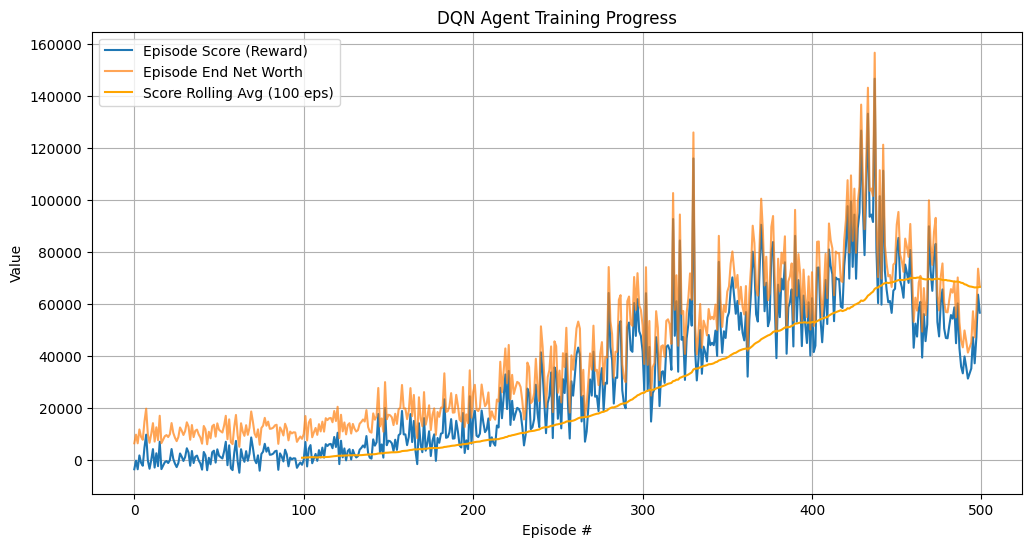


Starting Backtesting...
Step: 4, Action: Buy, Price: 92.93, Net Worth: 9990.01, Cost: 9.99
Step: 12, Action: Sell, Price: 90.37, Net Worth: 9704.85, Cost: 9.71
Step: 13, Action: Buy, Price: 90.15, Net Worth: 9695.16, Cost: 9.70
Step: 19, Action: Sell, Price: 106.03, Net Worth: 11392.43, Cost: 11.40
Step: 26, Action: Buy, Price: 110.20, Net Worth: 11381.05, Cost: 11.38
Step: 34, Action: Sell, Price: 122.72, Net Worth: 12662.23, Cost: 12.67
Step: 36, Action: Buy, Price: 123.37, Net Worth: 12649.58, Cost: 12.65
Step: 42, Action: Sell, Price: 117.87, Net Worth: 12073.36, Cost: 12.09
Step: 50, Action: Hold, Net Worth: 12073.36
Step: 53, Action: Buy, Price: 107.34, Net Worth: 12061.30, Cost: 12.06
Step: 54, Action: Sell, Price: 109.03, Net Worth: 12238.60, Cost: 12.25
Step: 56, Action: Buy, Price: 105.53, Net Worth: 12226.37, Cost: 12.23
Step: 61, Action: Sell, Price: 113.88, Net Worth: 13181.40, Cost: 13.19
Step: 66, Action: Buy, Price: 112.11, Net Worth: 13168.23, Cost: 13.17
Step: 67, Ac

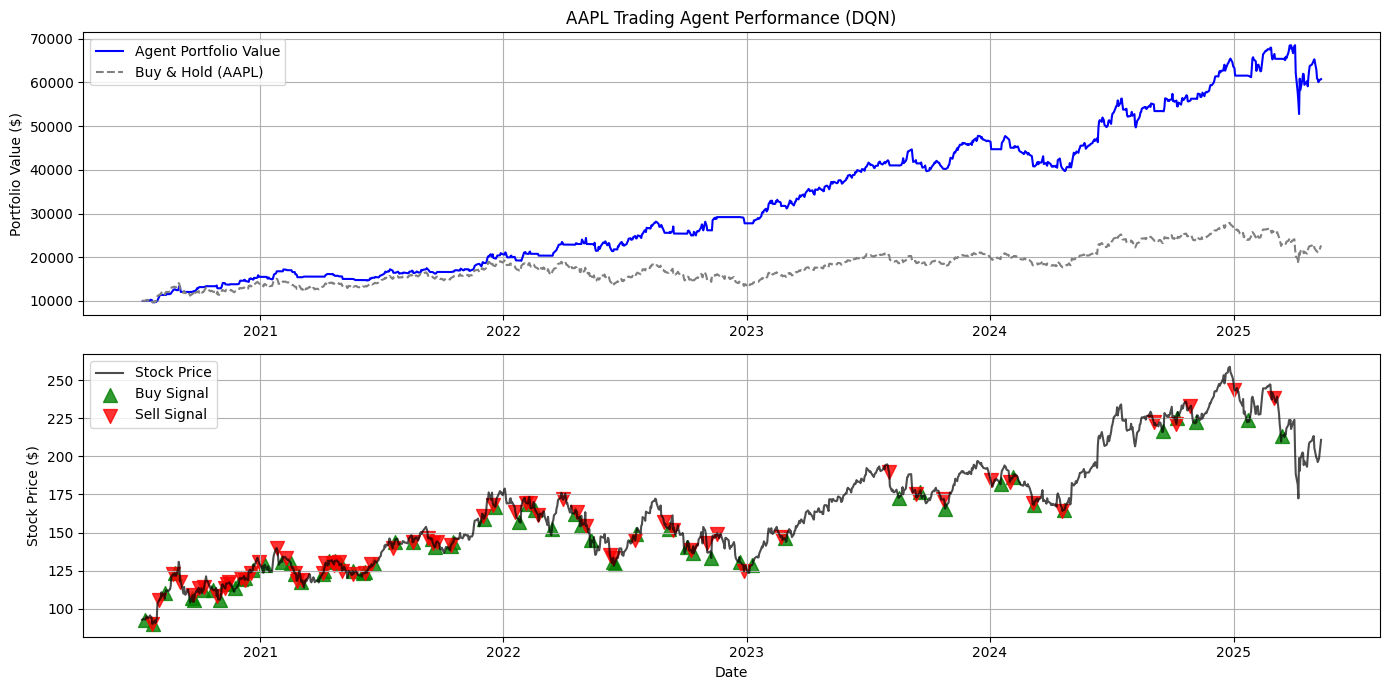

In [12]:
# 1. Load and Prepare Data
# !! Important for real evaluation: Split data here !!
# train_data, test_data = train_test_split(...)
# scaler = StandardScaler().fit(train_features)
# train_features_scaled = scaler.transform(train_features)
# test_features_scaled = scaler.transform(test_features)
# For simplicity, using all data for both training and 'backtesting' here
try:
    stock_data_full, feature_data_scaled, feature_scaler = load_and_prepare_data(
        TICKER, PERIOD, INTERVAL, N_LAGS
    )

    # 2. Create Environment
    # For Training (using the full dataset here, ideally use train split)
    train_env = TradingEnv(stock_data_full, feature_data_scaled, INITIAL_BALANCE, TRANSACTION_COST_PCT)

    # 3. Create Agent
    agent = DQNAgent(state_size=train_env.state_dim, action_size=train_env.action_space_n, seed=0)

    # 4. Train the Agent
    scores, net_worths = train_dqn(
        agent, train_env,
        n_episodes=NUM_EPISODES,
        max_t=MAX_T, # Can set this higher if needed
        eps_start=EPS_START,
        eps_end=EPS_END,
        eps_decay=EPS_DECAY
    )

    # Plot training progress (Optional)
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='Episode Score (Reward)')
    plt.plot(np.arange(len(net_worths)), net_worths, label='Episode End Net Worth', alpha=0.7)
    # Moving average for scores
    rolling_avg = pd.Series(scores).rolling(window=100).mean()
    plt.plot(rolling_avg, label='Score Rolling Avg (100 eps)', color='orange')
    plt.ylabel('Value')
    plt.xlabel('Episode #')
    plt.title('DQN Agent Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optional: Save the trained model
    # torch.save(agent.qnetwork_local.state_dict(), f'{TICKER}_dqn_model.pth')
    # print(f"Trained model saved to {TICKER}_dqn_model.pth")

    # Optional: Load a pre-trained model
    # agent.qnetwork_local.load_state_dict(torch.load(f'{TICKER}_dqn_model.pth'))
    # agent.qnetwork_target.load_state_dict(torch.load(f'{TICKER}_dqn_model.pth')) # Also load into target
    # print("Loaded pre-trained model.")


    # 5. Backtest the Trained Agent
    # Create a separate environment instance for backtesting
    # Ideally use the test split of the data here
    backtest_env = TradingEnv(stock_data_full, feature_data_scaled, INITIAL_BALANCE, TRANSACTION_COST_PCT)
    final_worth, total_return, trade_history = backtest(agent, backtest_env, feature_scaler)

except ValueError as e:
    print(f"Error during data loading or processing: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()